In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from ewstools import ewstools

In [4]:
from pathlib import Path

In [62]:
df = pd.read_csv('spdata.csv')
df.head()

Date        Close
0     1  2096.949951
1     2  2099.330078
2     3  2105.260010
3     4  2099.129883
4     5  2109.409912

In [63]:
df.set_index('Date');

In [64]:
df_traj = pd.DataFrame(df)
df_traj.set_index('Date', inplace=True)

In [68]:
rw = 0.5 # rolling window
span = 0.5 # Lowess span
lags = [1,2,3] # autocorrelation lag times to compute
ews = ['var','sd','ac','skew','kurt','ac','smax','cf','aic'] # EWS to compute (let's do all of them)
ham_length = 80 # number of data points in Hamming window
ham_offset = 0.5 # proportion of Hamming window to offset by upon each iteration
pspec_roll_offset = 20 # offset for rolling window when doing spectrum metrics

In [2]:
??ewstools.ews_compute

Object `ewstools.ews_compute` not found.


In [69]:
ews_dic = ewstools.ews_compute(df_traj['Close'], 
                          roll_window = rw, 
                          span = span,
                          lag_times = lags, 
                          ews = ews,
                          upto=755)

In [70]:
# The DataFrame of EWS
df_ews = ews_dic['EWS metrics']
# The DataFrame of power spectra
df_pspec = ews_dic['Power spectrum']
# The DataFrame of ktau values
df_ktau = ews_dic['Kendall tau']

In [59]:
df_ews.iloc[640:700];

In [71]:
df_ktau

Lag-3 AC  Kurtosis  Smax/Var  Standard deviation      Smax  Lag-1 AC  \
0  0.320685 -0.292625 -0.157895            0.874021  0.918129   0.37125   

   Lag-2 AC  Variance  
0  0.338722  0.874021

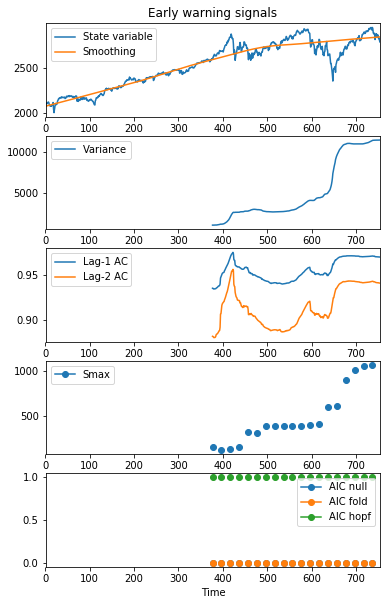

In [72]:
## Plot of trajectory, smoothing and EWS of var (x or y)
fig1, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,10))
df_ews[['State variable','Smoothing']].plot(ax=axes[0],
          title='Early warning signals')
df_ews['Variance'].plot(ax=axes[1],legend=True)
df_ews[['Lag-1 AC','Lag-2 AC']].plot(ax=axes[2],legend=True)
df_ews['Smax'].plot(ax=axes[3],legend=True, marker='o')
df_ews[['AIC null','AIC fold','AIC hopf']].plot(ax=axes[4],legend=True, marker='o')

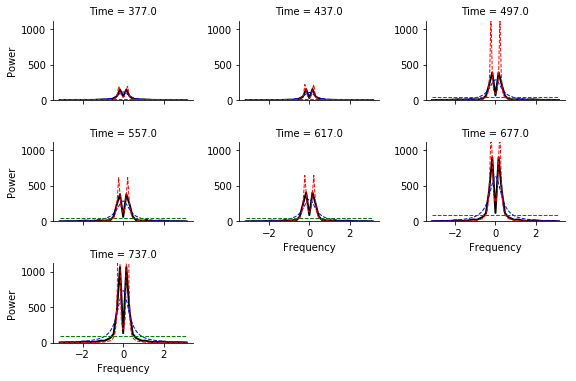

In [73]:
 def plot_pspec_grid(tVals):
    '''
    Plot a grid of power spectra, their fits, and AIC values at different times leading up to the bifurcation
    
    Args
    --------
    tVals: An array of time values at which to plot the power spectrum
    
    Returns
    ----------
    A grid plot
    
    '''
    g = sns.FacetGrid(df_pspec.loc[t_display].reset_index(), 
                  col='Time',
                  col_wrap=3,
                  sharey=False,
                  aspect=1.5,
                  height=1.8
                  )

    g.map(plt.plot, 'Frequency', 'Empirical', color='k', linewidth=2)
    g.map(plt.plot, 'Frequency', 'Fit fold', color='b', linestyle='dashed', linewidth=1)
    g.map(plt.plot, 'Frequency', 'Fit hopf', color='r', linestyle='dashed', linewidth=1)
    g.map(plt.plot, 'Frequency', 'Fit null', color='g', linestyle='dashed', linewidth=1)
    # Axes properties
    axes = g.axes
    # Set y labels
    for ax in axes[::3]:
        ax.set_ylabel('Power')
        # Set y limit as max power over all time
        for ax in axes:
            ax.set_ylim(top=1.05*max(df_pspec['Empirical']), bottom=0)
#            ax.set_yscale('log')
       
    return g

#  Choose time values at which to display power spectrum
t_display = df_pspec.index.levels[0][::3].values

plot_pspec = plot_pspec_grid(t_display)